In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import hstack
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.model_selection import train_test_split
import xgboost as xgb
import nltk

pal = sns.color_palette()

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



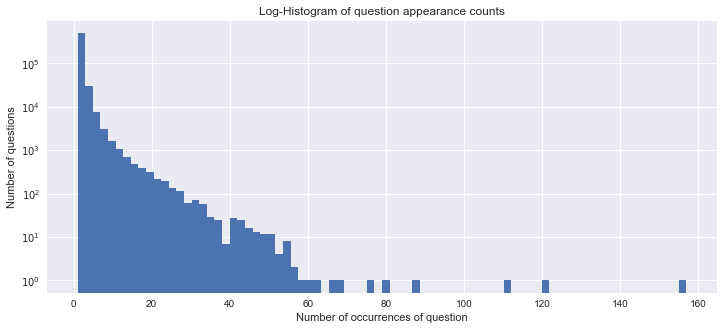

In [4]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts().values, bins=80)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurrences of question')
plt.ylabel('Number of questions')
print()

There are quite a number of duplicate questions. 

# Analysis
In the increasing level of specificity, we do
* Text Analysis: number of words and characters per question, most common words
* Semantic Analysis: presence of punctuation and other similar stuff (e.g. full stops, commas, numbers, capitalization, and in this case, [math] tags.
* Initial Feature Analysis: compare common words after removal of common words, using term frequency–inverse document frequency (TF-IDF)
* Advanced Feature Analysis: Latent semantic analysis, Word2Vec, "magic features"

We pool questions together in a Series for training and test data respectively.

In [5]:
train_qns = pd.Series(df_train["question1"].tolist() + df_train["question2"].tolist()).astype(str)
test_qns = pd.Series(df_test["question1"].tolist() + df_test["question2"].tolist()).astype(str)

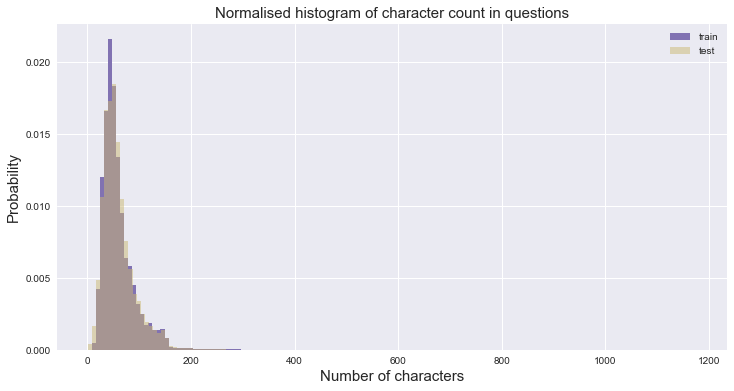

In [6]:
train_length = train_qns.apply(len)
test_length = test_qns.apply(len)

plt.figure(figsize=(12, 6))
plt.hist(train_length, bins=150, color=pal[3], normed=True, label="train")
plt.hist(test_length, bins=150, color=pal[4], normed=True, alpha=0.5, label="test")
plt.legend()
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

There seems to be some questions over 200 characters long. A quick search on Google tells us that the maximum character count for Quora questions is 150, so we should examine that range instead.

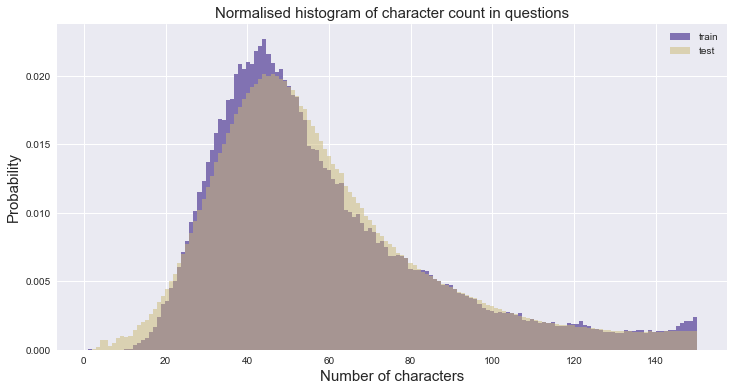

In [7]:
plt.figure(figsize=(12, 6))
plt.hist(train_length[train_length <= 150], bins=150, color=pal[3], normed=True, label="train")
plt.hist(test_length[test_length <= 150], bins=150, color=pal[4], normed=True, alpha=0.5, label="test")
plt.legend()
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
del train_length, test_length

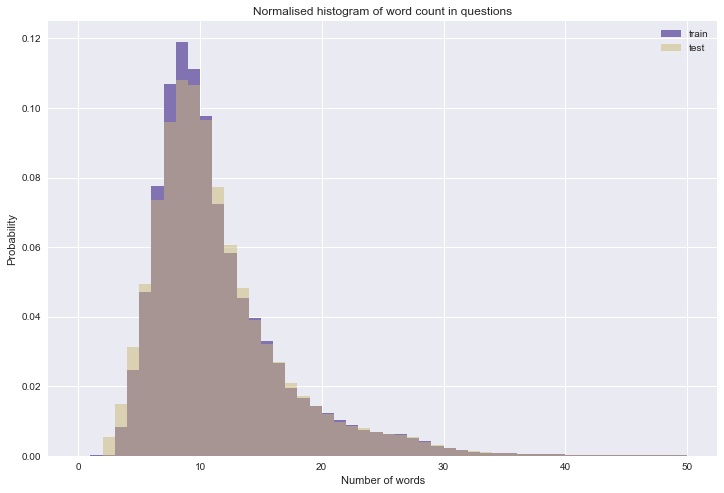

In [8]:
train_wlen = train_qns.apply(lambda s: len(s.split(" ")))
test_wlen = test_qns.apply(lambda s: len(s.split(" ")))

plt.figure(figsize=(12, 8))
plt.hist(train_wlen, bins=50, color=pal[3], range=[0, 50], normed=True, label="train")
plt.hist(test_wlen, bins=50, color=pal[4], range=[0, 50], alpha=0.5, normed=True, label="test")
plt.legend()
plt.title("Normalised histogram of word count in questions")
plt.xlabel("Number of words")
plt.ylabel("Probability")

del train_wlen, test_wlen

## Using scikit-learn's implementation of TF-IDF 

In [9]:
df_train.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [10]:
all_qns = pd.concat([train_qns, test_qns]).tolist()
del train_qns, test_qns, df_train, df_test

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [12]:
all_qns = list(set(all_qns))

In [13]:
vectorizer.fit(all_qns)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [14]:
print(len(all_qns))
import sys
print(sys.getsizeof(all_qns))
dir()

4789032
43101400


['In',
 'Out',
 'TfidfVectorizer',
 '_',
 '_11',
 '_13',
 '_3',
 '_6',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i2',
 '_i3',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 '_sh',
 'all_qns',
 'exit',
 'get_ipython',
 'hstack',
 'log_loss',
 'nltk',
 'np',
 'paired_cosine_distances',
 'pal',
 'pd',
 'plt',
 'qids',
 'quit',
 'roc_auc_score',
 'sns',
 'sys',
 'train_test_split',
 'vectorizer',
 'xgb']

In [15]:
all_qns_pd = pd.Series(all_qns)
all_qns_pd.to_csv("all_qns.csv", index=False)
del all_qns
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## Elementary fitting for comparing features

In [16]:
v1 = vectorizer.transform(df_train["question1"].values.astype(str))
v2 = vectorizer.transform(df_train["question2"].values.astype(str))
X = paired_cosine_distances(v1, v2)
y = df_train["is_duplicate"].values.astype(int)

MemoryError: 

In [ ]:
print(v1.shape, v2.shape)

In [ ]:
def scorer(X, y):
    X, X_cv, y, y_cv = train_test_split(X, y, test_size=0.2, random_state=0)
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = 0.02
    params['max_depth'] = 4

    d_train = xgb.DMatrix(X, label=y)
    d_valid = xgb.DMatrix(X_cv, label=y_cv)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)
    d_cv = xgb.DMatrix(X_cv)
    y_cv_pred = bst.predict(d_cv)

    return log_loss(y_cv, y_cv_pred)

In [ ]:
X = X.reshape(-1, 1)
scorer(X, y)